#home exam 
## Nadav Har-Tuv

In [ ]:
from google.colab import files
files.upload()


Start by loading the data and packages. Since we wish to come up with a budget allocation between the networks, it makes sense to look at them seperately from the start.

In [177]:
# Load packages and data

# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
revenue = pd.read_csv("revenue.csv", index_col = 0, parse_dates= ['purchase_date'])
spend = pd.read_csv("spend.csv", index_col = 0, parse_dates= ['date'])
revenue['network'] = revenue['network'].astype('category')
revenue['network'] = revenue['network'].cat.rename_categories({'Facebook Ads':'Facebook Ads', 'googleadwords_int': 'Google Ads'})
revenue = revenue.rename(columns = {'purchase_date': 'date'})

revenue = pd.get_dummies(revenue, columns = ['subscription_duration'])




## EDA

First let's take a quick look at our data:

In [178]:
revenue.head()

,date,lt_subscription_id,network,campaign_id,revenue,subscription_duration_1m,subscription_duration_1y,subscription_duration_l
0,2021-09-04,2d7715f8-f790-4cde-b22c-d86906099819,Facebook Ads,efb6c572-20cc-4c5f-98f5-6b55d3516b92,2,1,0,0
1,2021-09-03,5a98a181-bb18-48be-96fe-4ab896ef6fad,Facebook Ads,03d81fca-6239-4019-a9d6-91be2d024dc5,3,0,1,0
2,2021-09-04,0291803a-1740-4b4b-8a51-d93576a5b92a,Facebook Ads,03d81fca-6239-4019-a9d6-91be2d024dc5,3,0,1,0
3,2021-09-04,fd3c4afd-af1d-4e55-812d-9f001b471d9e,Facebook Ads,9d41ee22-0d03-4b42-9e97-d0a984854cac,14,0,1,0
4,2021-09-01,72433e8b-8503-44c9-9185-189fb1fef050,Google Ads,788bfd0c-1a21-48b3-9ac9-398eb2ad38f1,6,0,1,0


The revenue data has 8 columns, the subscription ID has as many unique values as the number of rows and therefore it is not interesting to analyze:

In [179]:
revenue['lt_subscription_id'].nunique() == revenue.shape[0]

True

The date, network and revenue columns will help us to analyze the revenue over time and the campaign ID will help us to analyze the relation between spend and revenue. The subscription columns are probably completely correlated with the revenue, I will look into that later.

Now let's look at the spending:

In [180]:
spend.head()

,network,date,campaign_id,spend
0,Facebook Ads,2021-08-22,6bcda7a3-5f73-4b7d-80a0-bf03a5d6c631,819.000000
1,Facebook Ads,2021-08-23,9ca40d6c-616a-4100-a278-71902c9b9d7a,6739.000000
2,Facebook Ads,2022-02-17,869822da-d203-448b-ad58-9958dcfcc85f,61.954400
3,Facebook Ads,2021-07-16,8e9a39a3-7528-4282-ba67-27d40f692c90,546.651800
4,Google Ads,2021-11-30,92a9eac5-158c-4023-ad87-a75480619924,342.295473


This data set tells us how much we spent on each campaign of each network in each day.

Now let's look at how sales progress over time.

I will aggregate the data to a daily level and look what's going on. Since we are eventually interested at budget allocation between the networks, I will look at Facebook and Google seperately


Text(0, 0.5, 'Revenue')

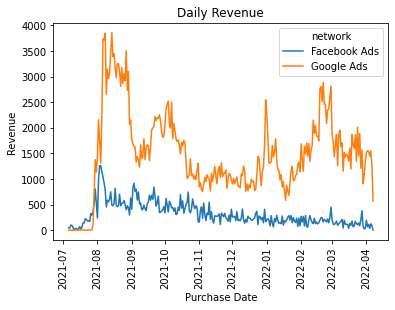

In [181]:
# Daily revenue plot
daily_revenue = revenue.groupby(['date', 'network']).sum()
daily_spend = spend.groupby(['date', 'network']).sum()

sns.lineplot(data = daily_revenue, x = 'date', y = 'revenue', hue = 'network')
plt.xticks(rotation = 'vertical')
plt.title('Daily Revenue')
plt.xlabel('Purchase Date')
plt.ylabel('Revenue')



The google revenue seems pretty stationary and the Facebook data seeme to have a downward trend. Let's test this:

In [182]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

print("ADF test for Google ads revenue:")
print(adf_test(daily_revenue.query("network == 'Google Ads'")['revenue']))
print("\n ADF test for Facebook ads revenue")
print(adf_test(daily_revenue.query("network == 'Facebook Ads'")['revenue']))

ADF test for Google ads revenue:
1. ADF :  -3.727385547180106
2. P-Value :  0.003744032357270897
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression: 266
5. Critical Values :
	 1% :  -3.455175292841607
	 5% :  -2.8724677563219485
	 10% :  -2.57259315846006
None

 ADF test for Facebook ads revenue
1. ADF :  -2.4889975749172195
2. P-Value :  0.11817433577400999
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression: 269
5. Critical Values :
	 1% :  -3.4548957220044336
	 5% :  -2.8723451788613157
	 10% :  -2.572527778361272
None


Our assumption is correct, the Google ad revenue is stationary (p-val = 0.0037) and the Facebook ad revenue is not stationary (p-val = 0.1182)

We also notice in this plot is that Google Ads are making significantly more money than Facebook Ads. However, this doesn't mean much yet until we will look at the spending.

Let's look if the subscriptions behave similarly to the revenue:

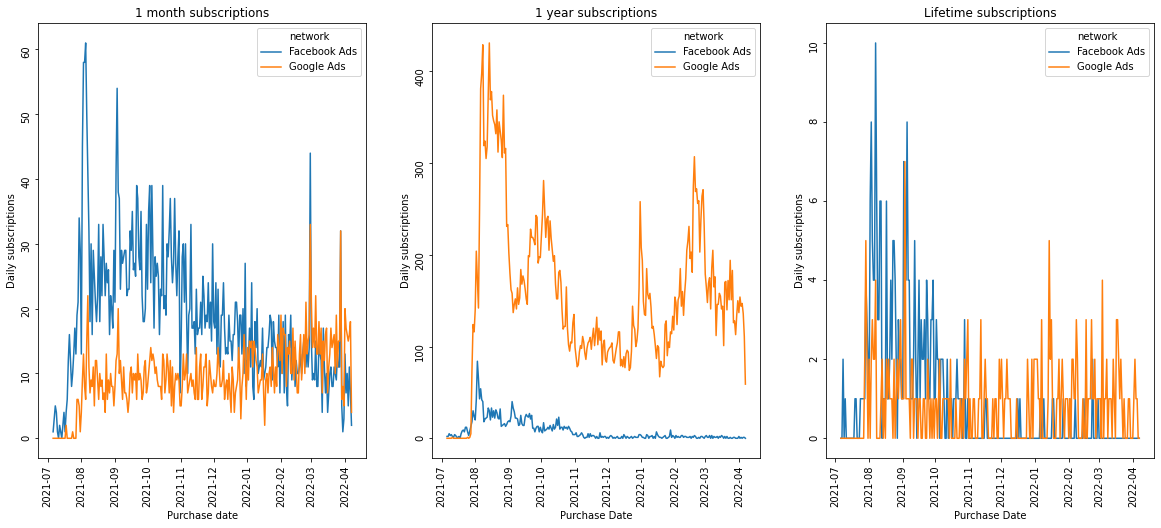

In [183]:
# Subscriptions plot

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8))
sns.lineplot(data = daily_revenue,x = 'date',y = 'subscription_duration_1m', hue = 'network', ax=ax1)
sns.lineplot(data = daily_revenue,x = 'date',y = 'subscription_duration_1y',hue = 'network',  ax=ax2)
sns.lineplot(data = daily_revenue,x = 'date',y = 'subscription_duration_l',hue = 'network', ax=ax3)
ax1.tick_params(labelrotation=90)
ax1.title.set_text('1 month subscriptions')
ax1.set(xlabel= 'Purchase date', ylabel = 'Daily subscriptions')
ax2.tick_params(labelrotation=90)
ax2.title.set_text('1 year subscriptions')
ax2.set(xlabel= 'Purchase Date', ylabel = 'Daily subscriptions')
ax3.tick_params(labelrotation=90)
ax3.title.set_text('Lifetime subscriptions')
ax3.set(xlabel= 'Purchase Date', ylabel = 'Daily subscriptions')
plt.show()

The subscriptions behave similarly to the revenue. The shape of the 1y subscriptions from Google is almost identical to the shape of the revenue from Google and the shape of the 1m subscriptions form Facebook is very similar to the shape of the revenue from Facebook.

I don't think that I need to bother with modeling the subscriptions since they are so strongly correlated with the revenue. From here on I will only focus on the revenue.

## Predicting the revenue for next month

Since the revenues from Google and Facebook behave so differently, I will model each one of them seperately and then aggregate the results. 

The data doesn't have many months so there probably isn't enough data to model the revenue on a monthly level. I will create a model based on the daily data and predict 30 days into the future. 

I will use the LSTM model, which is the most common model used in time series forecasting. I know that the ARIMA model is also popular, with more time I wouldv'e tested that model as well. The results for tha LSTM model are satisfactory so i'm pretty happy with this choice.

In [184]:
# Seperate to Facebook daily data and Google daily data
import keras
import tensorflow as tf

from keras.preprocessing.sequence import TimeseriesGenerator

daily_revenue.drop(columns = ['subscription_duration_1m', 'subscription_duration_1y', 'subscription_duration_l'], inplace = True)

fb_daily = daily_revenue.query("network=='Facebook Ads'")
ggl_daily = daily_revenue.query("network=='Google Ads'")


In [185]:
# Split to train test

fb_data = fb_daily.values.reshape((-1,1))
ggl_data = ggl_daily.values.reshape((-1,1))


split_percent = 0.80
split = int(split_percent*len(fb_data))

fb_train = fb_data[:split]
ggl_train = ggl_data[:split]

fb_test = fb_data[split:]
ggl_test = ggl_data[split:]

dates = [i[0] for i in fb_daily.index]
train_dates = dates[:split]
test_dates = dates[split:]


I decided to model based on 10 days in the past, this number seems to give the best results. If I had more time I would test a set of values using cross validation and pick the one that has the lowest loss on the validation data.

In [186]:
# Create sample generators for the LSTM model

look_back = 10
fb_train_generator = TimeseriesGenerator(fb_train, fb_train, length=look_back, batch_size=20)
ggl_train_generator = TimeseriesGenerator(ggl_train, ggl_train, length=look_back, batch_size=10)

fb_test_generator = TimeseriesGenerator(fb_test, fb_test, length=look_back, batch_size=20)
ggl_test_generator = TimeseriesGenerator(ggl_test, ggl_test, length=look_back, batch_size=1)



Epoch 1/35
11/11 [==============================] - 1s 5ms/step - loss: 177258.5312 - root_mean_squared_error: 421.0208
Epoch 2/35
11/11 [==============================] - 0s 5ms/step - loss: 163054.9844 - root_mean_squared_error: 403.8007
Epoch 3/35
11/11 [==============================] - 0s 6ms/step - loss: 140630.1094 - root_mean_squared_error: 375.0068
Epoch 4/35
11/11 [==============================] - 0s 6ms/step - loss: 97203.2031 - root_mean_squared_error: 311.7743
Epoch 5/35
11/11 [==============================] - 0s 7ms/step - loss: 43841.8945 - root_mean_squared_error: 209.3846
Epoch 6/35
11/11 [==============================] - 0s 6ms/step - loss: 37203.4648 - root_mean_squared_error: 192.8820
Epoch 7/35
11/11 [==============================] - 0s 6ms/step - loss: 50454.1562 - root_mean_squared_error: 224.6200
Epoch 8/35
11/11 [==============================] - 0s 7ms/step - loss: 45725.2656 - root_mean_squared_error: 213.8347
Epoch 9/35
11/11 [===========================

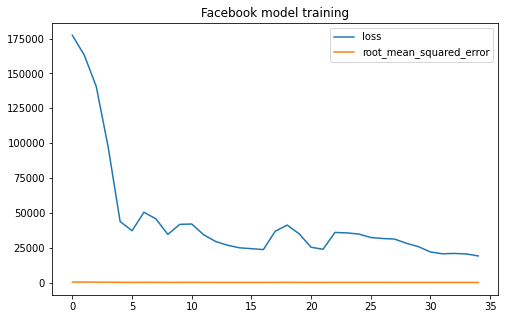

Epoch 1/35
21/21 [==============================] - 0s 5ms/step - loss: 572461.7500 - root_mean_squared_error: 756.6120
Epoch 2/35
21/21 [==============================] - 0s 5ms/step - loss: 323978.2812 - root_mean_squared_error: 569.1909
Epoch 3/35
21/21 [==============================] - 0s 6ms/step - loss: 213460.0156 - root_mean_squared_error: 462.0173
Epoch 4/35
21/21 [==============================] - 0s 6ms/step - loss: 203477.0312 - root_mean_squared_error: 451.0843
Epoch 5/35
21/21 [==============================] - 0s 6ms/step - loss: 238915.4844 - root_mean_squared_error: 488.7898
Epoch 6/35
21/21 [==============================] - 0s 6ms/step - loss: 217581.2344 - root_mean_squared_error: 466.4560
Epoch 7/35
21/21 [==============================] - 0s 6ms/step - loss: 195722.4531 - root_mean_squared_error: 442.4053
Epoch 8/35
21/21 [==============================] - 0s 6ms/step - loss: 178722.4375 - root_mean_squared_error: 422.7557
Epoch 9/35
21/21 [======================

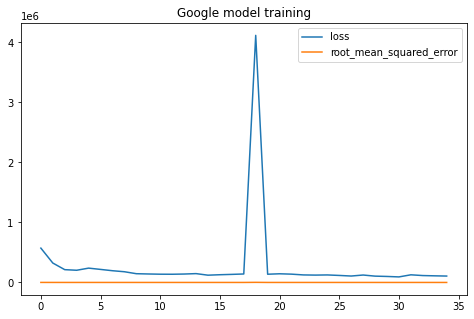

In [197]:
# Creeate and train model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import datetime

model = Sequential()
model.add(
    LSTM(64,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=[RootMeanSquaredError()])

num_epochs = 35
history = model.fit(fb_train_generator, epochs=num_epochs, verbose=1)
fb_prediction =  model.predict(fb_test_generator).reshape((-1))
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Facebook model training")
plt.show()

history = model.fit(ggl_train_generator, epochs=num_epochs, verbose=1)
ggl_prediction = model.predict(ggl_test_generator).reshape(-1)
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title("Google model training")
plt.show()



There are more hyper parameters here that could have been chosen with cross validation if I had more time: The number of epochs, and number of hidden layers and neurons in the network. For the purpose of the exam I tried a few options and chose the ones that gave the best MSE on the test data. Performing cross validation for time series data is a little bit tricky, we can't just throw out different chunks of the data each time but what we can do is validate with a "sliding window"; we select a certain window size and perform the prediction for the next observation and repeat this for all windows in the training data.  

(array([737972., 738003., 738034., 738064., 738095., 738125., 738156.,
        738187., 738215., 738246.]),
 <a list of 10 Text major ticklabel objects>)

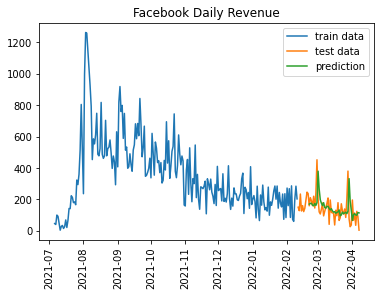

In [198]:
# Plot Facebook daily revenue and prediction 

fb_train_for_plot = fb_train.reshape((-1))
fb_test_for_plot = fb_test.reshape((-1))


sns.lineplot(x = train_dates, y = fb_train_for_plot, label = "train data")
sns.lineplot(x = test_dates, y = fb_test_for_plot, label = 'test data')
sns.lineplot(x = test_dates[look_back:], y = fb_prediction, label = 'prediction')
plt.title("Facebook Daily Revenue")
plt.xticks(rotation = 'vertical')


Text(0.5, 1.0, 'Google Daily Revenue')

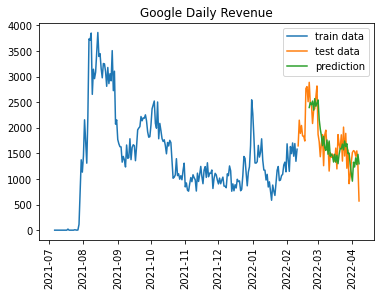

In [199]:
# Plot Google daily revenue and prediction
ggl_train_for_plot = ggl_train.reshape((-1))
ggl_test_for_plot = ggl_test.reshape((-1))

sns.lineplot(x = train_dates, y = ggl_train_for_plot, label = "train data")
sns.lineplot(x = test_dates, y = ggl_test_for_plot, label = 'test data')
sns.lineplot(x = test_dates[look_back:], y = ggl_prediction, label = 'prediction')
plt.xticks(rotation = 'vertical')
plt.title("Google Daily Revenue")

For both models the results seem decent. The loss function converges and the prediction plot looks pretty close to the test data. However, these results are far from perfect, a better model should also include the spending. This requires more technique and I probably shouldv'e done it if I had more time.

The RMSE for Facebook model on the test data is:

In [200]:
# Evaluate
np.sqrt(np.mean((fb_test.reshape((-1))[look_back:] - fb_prediction)**2))

94.12685545825293

And the RMSE for the Google model on the test data is 

In [201]:
# Evaluate
np.sqrt(np.mean((ggl_test.reshape((-1))[look_back:] - ggl_prediction)**2))

344.34299773530023

These results are not amazing, but they are also not bad, given how noisy the data is. The rmse on the training data is close to the rmse on the test data, indiceting that the model generalizes well. Regarding the errors, the predictions seem to follow the general trend of the data but miss out on some of the larger peaks. This is not such basd news since we are ultimately interested in the monthly prediction and therefore the daily peaks will probably cancel eachother out on average.

In [ ]:
# Predict revenue
fb_data = fb_data.reshape((-1))
ggl_data = ggl_data.reshape((-1))


def predict(num_prediction, model, data):
    prediction_list = data[-look_back:]
    
    for i in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = dates[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates


num_prediction = 30
forecast_dates = predict_dates(num_prediction)


model.fit(TimeseriesGenerator(fb_data, fb_data, length=look_back, batch_size=20), epochs=num_epochs, verbose=1)
fb_forecast = predict(num_prediction, model, fb_data)

model.fit(TimeseriesGenerator(ggl_data, ggl_data, length=look_back, batch_size=20), epochs=num_epochs, verbose=1)
ggl_forecast = predict(num_prediction, model, ggl_data)

The predicted revenue for the next month is:

In [203]:
print("Facebook forecast: ", sum(fb_forecast))
print("Google forecast: ", sum(ggl_forecast))

Facebook forecast:  1626.5607452392578
Google forecast:  45431.62365722656


This seems quite reasonble when looking at previous months:

Text(0.5, 0, 'Month')

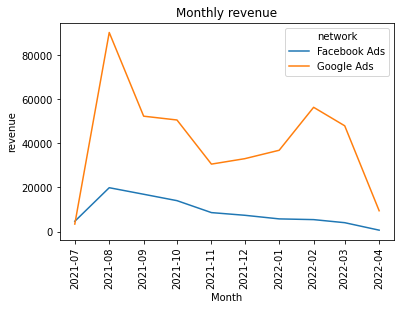

In [205]:
# Plot monthly revenue

daily_revenue['month'] = pd.DatetimeIndex(daily_revenue.reset_index()['date']).month
daily_revenue['year'] = pd.DatetimeIndex(daily_revenue.reset_index()['date']).year
daily_revenue['date_monthly'] = pd.to_datetime(daily_revenue[['year','month']].assign(DAY=1))
monthly_revenue = daily_revenue.groupby(['date_monthly','network']).sum()


monthly_revenue
sns.lineplot(data =monthly_revenue, x= 'date_monthly', y = 'revenue', hue = 'network')
plt.xticks(rotation = 'vertical')
plt.title("Monthly revenue")
plt.xlabel("Month")

## Relation between revenue to spend and budget allocation

In order to determine how to allocate the budget between the networks we first need to look at the function of revenue vs. spend for each of the networks. I assume that this function will be increasing with diminishing marginal returns (positive first derivative, negative second derivative). This function can be estimated by looking at every campaign as a data point and computing how much was spent on it and how much was earned from it. Once we have this function we can estimate the derivative at each point $\frac{Δrevenue}{Δspend}$. Once we have the local derivatives, our decision can be to always invest where the derivative is largest. For example, if both example, if both derivative functions are monotonically decreasing and intersect at a point $x$ then we would invest up to \$$x$ of our budget in the network with the higher derivative for $y\leq x$ and the rest of our budget in the other network.

In [206]:
# Summarize each dataset by campaign
revenue_summarized_by_campaign = revenue.groupby(['network', 'campaign_id']).sum()
spend_summarized_by_campaign = spend.groupby(['network', 'campaign_id']).sum()
merged_by_campaign = pd.merge(revenue_summarized_by_campaign, spend_summarized_by_campaign, on = ['network', 'campaign_id'])



Text(0.5, 1.0, 'Revenue vs. Spend')

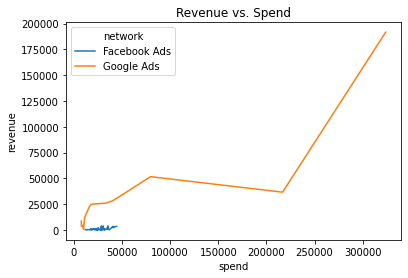

In [207]:
# Plot revenue vs. spend

sns.lineplot(data = merged_by_campaign, x= 'spend', y ='revenue', hue = 'network')
plt.title('Revenue vs. Spend')

This plot is very hard to interpret since some Google campaigns have a much larger spend than all of the Facebook campaigns. Let's look at the campaigns that we are spending up to 50k on:

Text(0.5, 1.0, 'Revenue vs. Spend for campaigns below 50k spend')

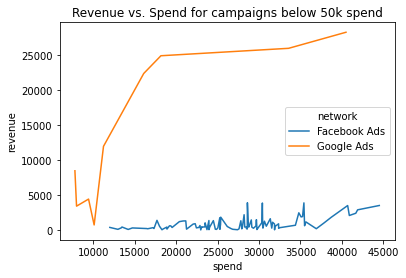

In [208]:
# Plot revenue vs. spend for spend<50K

sns.lineplot(data = merged_by_campaign[merged_by_campaign['spend']<50000], x= 'spend', y ='revenue', hue = 'network')
plt.title('Revenue vs. Spend for campaigns below 50k spend' )

The Google data behaves exactly as expected. However, the Facebook data is not at all as expected. The Facebook data is extremely noisy to a point where it is very hard to learn anything from it. I tried to run a regression of revenue on (year, month, day) and use the residuals instead of the revenue to control for seasonalitiy but that didn't really improve the situation. I also tried to smooth the Facebook data by using kernel regression but that didn't help much either...

I think that the only thing that we can learn from this data is that Google has a very nice return on investment up to about 18K and after that it might be wise to consider other investments. The ROI does grow back again at 35K and at 225K but there are very few data points there so it is probably not wise to make bussines decisions based on them.

I assume that maybe with more data we can get smoother plots and therefore better insights. Also I assume that the networks are not independent of eachother, we should probably model how they assist eachother. 

It can also be insightful to look at the revenue and spending over time and see how they behave together.

The revenue and spending are on different scales and therefore it makes sense to look at the plot of their logs in order to look at the change in percentage rather than the absolute change.

In the plots below we can see that for Google, the spending and revenue are very closely connected. However, for Facebook, it seems that the revenue is not tightly connected to the spending, the revenue is steadily decreasing, regardless of the spending. This probably means that our current investments in Facebook are not very wise and should be looked further into

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Daily log Revenue and Spending - Facebook')

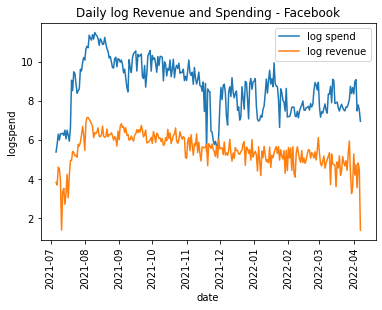

In [160]:
# Plot log daily revenue and log daily spend for Facebook

daily_revenue_spend = pd.merge(daily_revenue, daily_spend, on = ['date', 'network']).reset_index()
daily_revenue_spend['logspend'] = np.log(daily_revenue_spend['spend'])
daily_revenue_spend['logrevenue'] = np.log(daily_revenue_spend['revenue'])

sns.lineplot(data =daily_revenue_spend.query('network == "Facebook Ads"'), x='date', y='logspend', label = 'log spend')
sns.lineplot(data =daily_revenue_spend.query('network == "Facebook Ads"'), x='date', y='logrevenue', label = 'log revenue')
plt.xticks(rotation = 'vertical')

plt.title('Daily log Revenue and Spending - Facebook')


Text(0.5, 1.0, 'Daily log Revenue and Spending - Google')

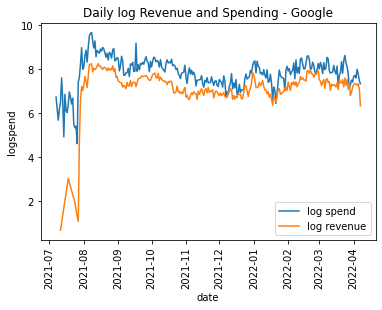

In [ ]:
# Plot log daily revenue and log daily spend for Google

sns.lineplot(data =daily_revenue_spend.query('network == "Google Ads"'), x='date', y='logspend', label = 'log spend')
sns.lineplot(data =daily_revenue_spend.query('network == "Google Ads"'), x='date', y='logrevenue', label = 'log revenue')
plt.xticks(rotation = 'vertical')

plt.title('Daily log Revenue and Spending - Google')


It looks like for Google, the spending and revenue are stronger correlated than in Facebook. 
Let's check that. I will look at the Spearman correlation coefficient and not the Pearson coefficient because I don't really care about a linear relationship, I only care if they go up and down together. 

In [168]:
# Compute correlation between spend and revenue

from scipy.stats import pearsonr, spearmanr

print("Spearman correlation between Facebook ads spending and revenue:")
print(spearmanr(daily_revenue_spend.query("network == 'Facebook Ads'")['revenue'],daily_revenue_spend.query("network == 'Facebook Ads'")['spend'])[0])
print("Spearman correlation between Google ads spending and revenue:")
print(spearmanr(daily_revenue_spend.query("network == 'Google Ads'")['revenue'],daily_revenue_spend.query("network == 'Google Ads'")['spend'])[0])

Spearman correlation between Facebook ads spending and revenue:
0.733104653126877
Spearman correlation between Google ads spending and revenue:
0.8385223276084282


We see that for Google there really is a stronger correlation than for Facebook.

## Summary to stakeholders

Our revenue is currently in a downward trend. I've tried to analyze the reasons for the decrease in our revenue and it seems to me that the main reason is bad investment in Facebook advertising. There seems to be a pretty weak relationship between the amount we are investing in Facebook and the amount we are earning from there. We must further investigate the Facebook advertising in order to understand how to make it work.

On the other hand, on Google we are doing great, there is a strong connection between money spent and revenue, we should investigate if there is for even more investment there. The last month has been fairly weak in terms of the revenue from Google ads but I believe that this is temporary and that in the long run this is a good investment.